In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import WindowDataset
import CustomModels
import CustomMetrics
import CustomWindowGenerator

%load_ext autoreload
%autoreload 2

# DATASET

## Load Dataset

In [2]:
data_horaria_estandarizada_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Horaria_Estandarizada.xlsx')
data_horaria_estandarizada = pd.read_excel(data_horaria_estandarizada_path)
data_horaria_estandarizada = data_horaria_estandarizada.set_index('Fecha')

In [3]:
precio_bolsa_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Precio_Bolsa_Estandarizada.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

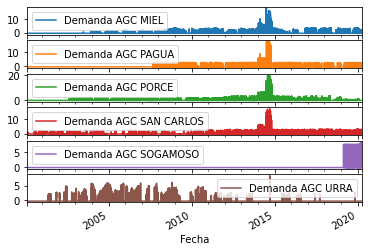

In [4]:
plot_cols = data_horaria_estandarizada.columns[-6:]
plot_features = data_horaria_estandarizada[plot_cols]
_ = plot_features.plot(subplots=True)

In [5]:
full_df = pd.concat([data_horaria_estandarizada,precio_bolsa],axis=1)
full_df.shape,data_horaria_estandarizada.shape,precio_bolsa.shape

((176760, 85), (176760, 84), (176760, 1))

In [6]:
train_df = full_df[(full_df.index >= '2000-01-01') & (full_df.index < '2019-01-01')]
val_df = full_df[(full_df.index >= '2019-01-01') & (full_df.index < '2020-01-01')]
test_df = full_df[full_df.index >= '2019-12-31']

train_df.shape,val_df.shape,test_df.shape

((165816, 85), (8760, 85), (2208, 85))

## Build Window

In [7]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA', 'Generacion CHIVOR',
          'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
          'Generacion GUAVIO', 'Generacion LA TASAJERA', 'Generacion MIEL',
          'Generacion PAGUA', 'Generacion PLAYAS', 'Generacion PORCE',
          'Generacion SAN CARLOS', 'Generacion SOGAMOSO', 'Generacion URRA','$kWh']
#output_columns = inputs_columns

#inputs_columns = ['$kWh']
output_columns = ['$kWh']

In [8]:
window_train = CustomWindowGenerator.MyWindowDatasetGenerator(data=train_df, times=24, shift=1,
                                                              input_signals=inputs_columns, output_signals=output_columns)

train_generator = window_train.make_dataset(train_df,batch_size=16,suffle=False)

In [9]:
window_val = CustomWindowGenerator.MyWindowDatasetGenerator(data=val_df, times=24, shift=1,
                                                            input_signals=inputs_columns, output_signals=output_columns)

val_generator = window_val.make_dataset(val_df,batch_size=16,suffle=False)

In [10]:
window_test = CustomWindowGenerator.MyWindowDatasetGenerator(data=test_df, times=24, shift=24,
                                                             input_signals=inputs_columns, output_signals=output_columns)

test_generator = window_test.make_dataset(test_df,batch_size=16,suffle=False,sequence_stride=24)

# MODELS

## Instantiate Models

In [11]:
custom_rnn  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Instantiate metrics dicts

In [12]:
val_performance = dict()
performance = dict()

## Compile & Fit Method

In [13]:
def compile_and_fit(model, window_train, window_val, epochs, steps_per_epoch, val_steps,patience):
    """
    Este método se encarga de definir las funciones Callback, compilar y además realizar entrenar
    el modelo. Entre las funciones Callback que se definen aquí están: Logs de TensorBoard, Redu-
    cción del Learning Rate cuando la métrica se queda estancada y Frenado del proceso de  entre-
    namient.
    Input:
        - model: Estimador que se va a entrenar.
        - window_train: Generador de datos con el cual se va a entrenar.
        - window_val: Generador de datos con el cual se va a evaluar.
        - epochs: Entero con las épocas de entrenamiento.
        - steps_per_epoch: Entero con la cantidad de pasos por época.
        - val_steps: Entero con los pasos por época para evaluación.
        - patience: Entero que determina cuantas epocas pasaran antes de ejecutar una acción del
        callback.
    Output:
        - history: Diccionario con los resultados del entrenamiento del modelo.
    """
    log_dir = os.path.join('logs',model.name)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=False,
                                                          update_freq='epoch')
    
    callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                              factor=0.1,
                                                              min_lr=1e-4,
                                                              patience=0,
                                                              verbose=1)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    callbacks = [callback_tensorboard,callback_reduce_lr,early_stopping]
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError(),
                           CustomMetrics.symmetric_mean_absolute_percentage_error])
    
    history = model.fit(x=window_train,epochs=epochs,steps_per_epoch=steps_per_epoch,
              validation_data=window_val,validation_steps=val_steps,callbacks=callbacks)
    
    return history

## Predictions & Plot

In [14]:
def generate_predictions_style_1(inputs,labels,model):
    batch_predictions = list()
    for batch in inputs:

        flat_inputs_size = batch.shape[0]

        predicted_signal = list()
        predicted_signal_idx = 0

        for i in range(0,flat_inputs_size):

            first_signals = batch[i:24,:-1]
            repeated_signals = tf.repeat(batch[23:24,:-1], i, axis=0)
            first_signals = tf.concat([first_signals,repeated_signals],axis=0)

            last_signal = tf.reshape(batch[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

            signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
            signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)

            predictions = model.predict(signals_to_predict)
            predicted_signal.append(predictions)

        batch_predictions.append(predicted_signal)

    batch_predictions = tf.reshape(tf.convert_to_tensor(batch_predictions),labels.shape)
    return batch_predictions

In [15]:
def generate_predictions_style_2(inputs,labels,model):
    batch_predictions = list()
    for batch in inputs:

        flat_inputs_size = batch.shape[0]

        predicted_signal = list()
        predicted_signal_idx = 0

        for i in range(0,flat_inputs_size):

            first_signals = batch[:24,:-1]

            last_signal = tf.reshape(batch[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

            signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
            signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)

            predictions = model.predict(signals_to_predict)
            predicted_signal.append(predictions)

        batch_predictions.append(predicted_signal)

    batch_predictions = tf.reshape(tf.convert_to_tensor(batch_predictions),labels.shape)
    return batch_predictions

In [16]:
def plot_comparison(inputs,predictions):
    signal_true = inputs[:,:,-1]
    flat_signal_true = tf.reshape(signal_true, [-1,1])

    signal_pred = predictions[:,:,-1]
    flat_signal_pred = tf.reshape(signal_pred, [-1,1])

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(flat_signal_true, label='true')
    plt.plot(flat_signal_pred, label='pred')

    plt.ylabel('Precio en Bolsa Nacional')
    plt.legend()
    plt.show()

In [17]:
def find_metrics_test(y_true,y_pred):
    
    mae_call = tf.keras.metrics.MeanAbsoluteError()
    mae_call.update_state(y_true,y_pred)
    mae = mae_call.result().numpy()
    
    mape_call = tf.keras.metrics.MeanAbsolutePercentageError()
    mape_call.update_state(y_true,y_pred)
    mape = mape_call.result().numpy()
    
    sMAPE_call = CustomMetrics.symmetric_mean_absolute_percentage_error(y_true,y_pred)
    sMAPE = sMAPE_call.numpy()
    
    return [mae,mape,sMAPE]

## Execute experiments

### Recurrent Neuronal Network

In [18]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomRNN(rnn_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 83)                8300      
_________________________________________________________________
dense (Dense)                (None, 1)                 84        
Total params: 8,384
Trainable params: 8,384
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = compile_and_fit(model=custom_rnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
  1/300 [..............................] - ETA: 0s - loss: 0.2948 - mean_absolute_error: 0.4361 - mean_absolute_percentage_error: 63.7440 - symmetric_mean_absolute_percentage_error: 96.0673WARNING:tensorflow:From C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
300/300 [==============================] - 8s 28ms/step - loss: 0.0228 - mean_absolute_error: 0.1124 - mean_absolute_percentage_error: 17.6967 - symmetric_mean_absolute_percentage_error: 17.7683 - val_loss: 0.5835 - val_mean_absolute_error: 0.6355 - val_mean_absolute_percentage_error: 4014.6338 - val_symmetric_mean_absolute_percentage_error: 104.4564
Epoch 2/100
300/300 [==============================] - 8s 25ms/step - loss: 0.0273 - mean_absolute_error: 0.1325 - mean_absolute_percentage

300/300 [==============================] - 7s 25ms/step - loss: 0.0759 - mean_absolute_error: 0.1978 - mean_absolute_percentage_error: 149.7184 - symmetric_mean_absolute_percentage_error: 74.2381 - val_loss: 0.2101 - val_mean_absolute_error: 0.3677 - val_mean_absolute_percentage_error: 385.5887 - val_symmetric_mean_absolute_percentage_error: 89.7436
Epoch 20/100
300/300 [==============================] - 8s 26ms/step - loss: 0.0213 - mean_absolute_error: 0.0942 - mean_absolute_percentage_error: 95.4090 - symmetric_mean_absolute_percentage_error: 47.4432 - val_loss: 0.1705 - val_mean_absolute_error: 0.3463 - val_mean_absolute_percentage_error: 975.5655 - val_symmetric_mean_absolute_percentage_error: 86.8859
Epoch 21/100
300/300 [==============================] - 8s 27ms/step - loss: 0.0108 - mean_absolute_error: 0.0761 - mean_absolute_percentage_error: 98.6842 - symmetric_mean_absolute_percentage_error: 27.0834 - val_loss: 0.1688 - val_mean_absolute_error: 0.3434 - val_mean_absolute_per

In [20]:
val_performance['DNN'] = custom_rnn.evaluate(val_generator)

546/546 [==============================] - 3s 5ms/step - loss: 0.2846 - mean_absolute_error: 0.4434 - mean_absolute_percentage_error: 699.5205 - symmetric_mean_absolute_percentage_error: 95.3411: 2s - loss: 0.3115 - mean_absolute_error: 0.5023 - mean_absolute_percentag


In [21]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

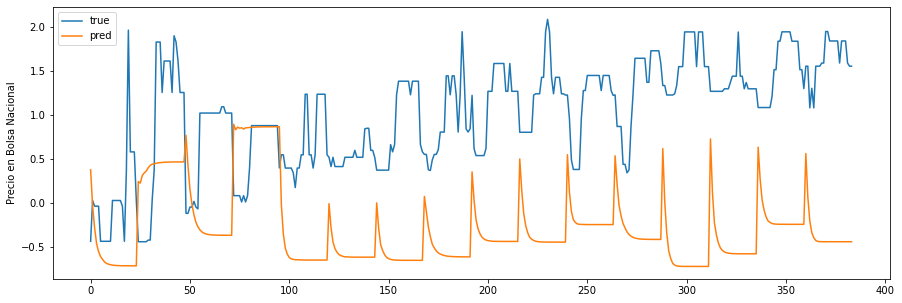

In [22]:
predictions = generate_predictions_style_1(inputs,labels,custom_rnn)
plot_comparison(labels,predictions)

In [23]:
performance['RNN'] = find_metrics_test(labels,predictions)

**Estilo 2:** Usando el último valor conocido.

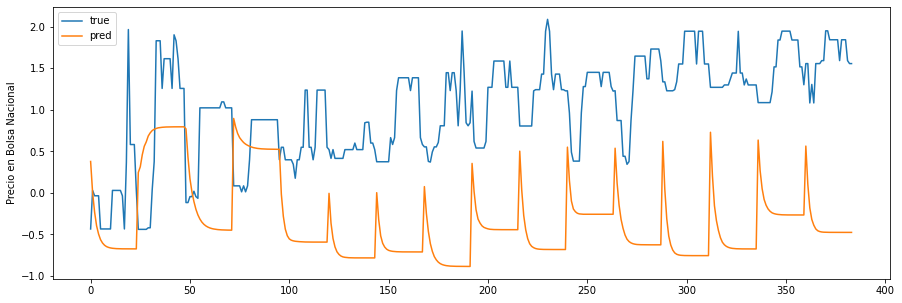

In [24]:
predictions = generate_predictions_style_2(inputs,labels,custom_rnn)
plot_comparison(labels,predictions)

### Long Short Term Memory

In [25]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 83)                33200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 84        
Total params: 33,284
Trainable params: 33,284
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = compile_and_fit(model=custom_lstm, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 6s 20ms/step - loss: 0.0243 - mean_absolute_error: 0.0968 - mean_absolute_percentage_error: 15.4400 - symmetric_mean_absolute_percentage_error: 15.8203 - val_loss: 0.7462 - val_mean_absolute_error: 0.7112 - val_mean_absolute_percentage_error: 2056.9836 - val_symmetric_mean_absolute_percentage_error: 151.6034
Epoch 2/100
300/300 [==============================] - 3s 11ms/step - loss: 0.0157 - mean_absolute_error: 0.0997 - mean_absolute_percentage_error: 22.8580 - symmetric_mean_absolute_percentage_error: 21.3265 - val_loss: 0.6687 - val_mean_absolute_error: 0.6914 - val_mean_absolute_percentage_error: 2337.7109 - val_symmetric_mean_absolute_percentage_error: 141.2588
Epoch 3/100
300/300 [==============================] - 4s 12ms/step - loss: 0.0104 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 14.4928 - symmetric_mean_absolute_percentage_error: 14.6762 - val_loss: 0.4233 - val_mean_absolute_error: 0.5278 - val_mean

In [27]:
val_performance['LSTM'] = custom_lstm.evaluate(val_generator)

546/546 [==============================] - 2s 4ms/step - loss: 0.5650 - mean_absolute_error: 0.6331 - mean_absolute_percentage_error: 2179.0276 - symmetric_mean_absolute_percentage_error: 95.1389


In [28]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

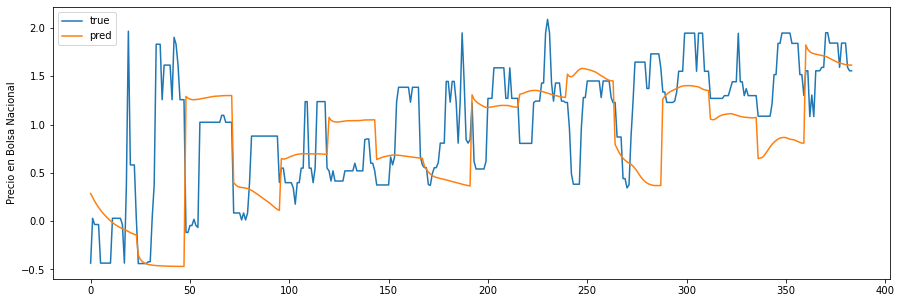

In [29]:
predictions = generate_predictions_style_1(inputs,labels,custom_lstm)
plot_comparison(labels,predictions)

In [30]:
performance['LSTM'] = find_metrics_test(labels,predictions)

**Estilo 2:** Usando el último valor conocido.

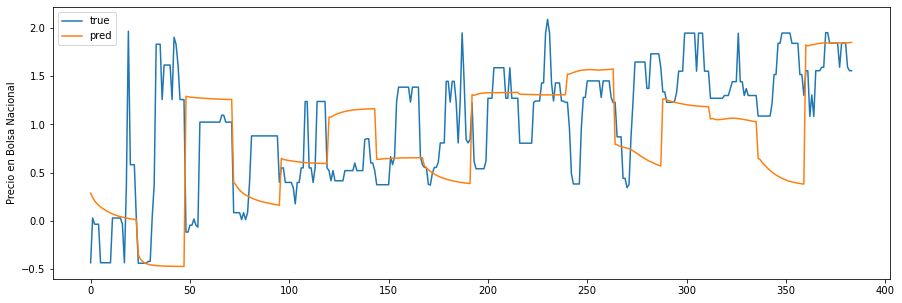

In [31]:
predictions = generate_predictions_style_2(inputs,labels,custom_lstm)
plot_comparison(labels,predictions)

### Gated Recurrent Unit

In [32]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomGRU(gru_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_gru_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 83)                25149     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 84        
Total params: 25,233
Trainable params: 25,233
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = compile_and_fit(model=custom_gru, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 27s 88ms/step - loss: 0.0130 - mean_absolute_error: 0.0834 - mean_absolute_percentage_error: 13.2182 - symmetric_mean_absolute_percentage_error: 13.2231 - val_loss: 0.6170 - val_mean_absolute_error: 0.6260 - val_mean_absolute_percentage_error: 1046.6464 - val_symmetric_mean_absolute_percentage_error: 138.9179
Epoch 2/100
300/300 [==============================] - 23s 76ms/step - loss: 0.0136 - mean_absolute_error: 0.0923 - mean_absolute_percentage_error: 21.0923 - symmetric_mean_absolute_percentage_error: 19.8404 - val_loss: 0.4718 - val_mean_absolute_error: 0.5494 - val_mean_absolute_percentage_error: 1040.7117 - val_symmetric_mean_absolute_percentage_error: 123.7444
Epoch 3/100
300/300 [==============================] - 23s 78ms/step - loss: 0.0129 - mean_absolute_error: 0.0860 - mean_absolute_percentage_error: 15.7931 - symmetric_mean_absolute_percentage_error: 16.1234 - val_loss: 0.3538 - val_mean_absolute_error: 0.4629 - val_m

300/300 [==============================] - 23s 77ms/step - loss: 0.0069 - mean_absolute_error: 0.0550 - mean_absolute_percentage_error: 69.3349 - symmetric_mean_absolute_percentage_error: 20.5678 - val_loss: 0.1072 - val_mean_absolute_error: 0.2667 - val_mean_absolute_percentage_error: 731.2786 - val_symmetric_mean_absolute_percentage_error: 68.4819
Epoch 22/100
300/300 [==============================] - 23s 77ms/step - loss: 0.0265 - mean_absolute_error: 0.0804 - mean_absolute_percentage_error: 39.2648 - symmetric_mean_absolute_percentage_error: 24.3191 - val_loss: 0.1114 - val_mean_absolute_error: 0.2686 - val_mean_absolute_percentage_error: 676.5592 - val_symmetric_mean_absolute_percentage_error: 67.8416
Epoch 23/100
300/300 [==============================] - 22s 73ms/step - loss: 0.0103 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 509.6423 - symmetric_mean_absolute_percentage_error: 42.1709 - val_loss: 0.1358 - val_mean_absolute_error: 0.3022 - val_mean_absolute_

In [34]:
val_performance['GRU'] = custom_gru.evaluate(val_generator)

546/546 [==============================] - 4s 7ms/step - loss: 0.0444 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 201.7312 - symmetric_mean_absolute_percentage_error: 32.2467


In [35]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

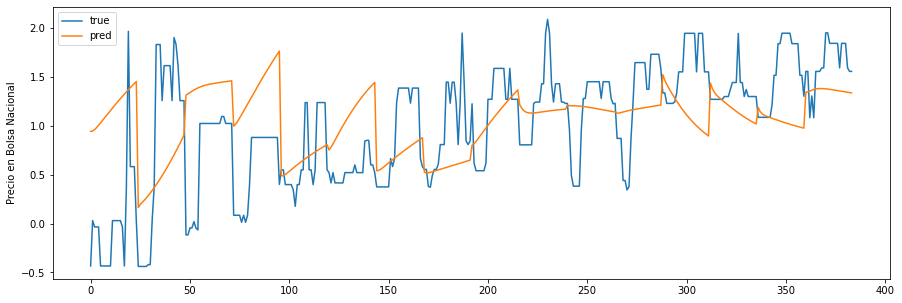

In [36]:
predictions = generate_predictions_style_1(inputs,labels,custom_gru)
plot_comparison(labels,predictions)

In [37]:
performance['GRU'] = find_metrics_test(labels,predictions)

**Estilo 2:** Usando el último valor conocido.

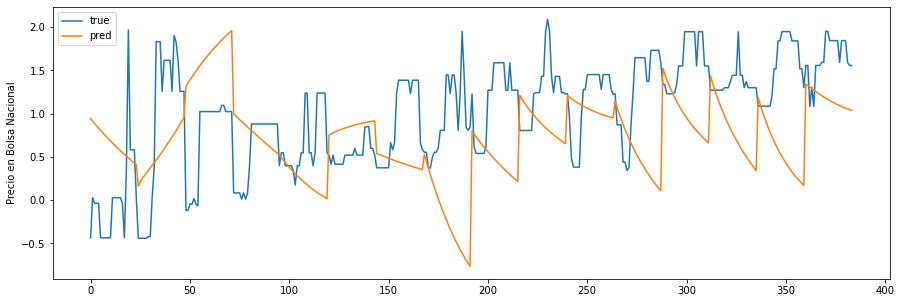

In [38]:
predictions = generate_predictions_style_2(inputs,labels,custom_gru)
plot_comparison(labels,predictions)

### Convolutional Neuronal Network

In [39]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomCNN(dropout_rate=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            2112      
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [40]:
history = compile_and_fit(model=custom_cnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 5s 17ms/step - loss: 0.1451 - mean_absolute_error: 0.3018 - mean_absolute_percentage_error: 46.7373 - symmetric_mean_absolute_percentage_error: 51.1914 - val_loss: 5.4536 - val_mean_absolute_error: 2.2351 - val_mean_absolute_percentage_error: 7640.1299 - val_symmetric_mean_absolute_percentage_error: 188.4271
Epoch 2/100
298/300 [============================>.] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1966 - mean_absolute_percentage_error: 43.6221 - symmetric_mean_absolute_percentage_error: 43.2900
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
300/300 [==============================] - 3s 9ms/step - loss: 0.0616 - mean_absolute_error: 0.1964 - mean_absolute_percentage_error: 43.7346 - symmetric_mean_absolute_percentage_error: 43.3238 - val_loss: 5.6362 - val_mean_absolute_error: 2.2605 - val_mean_absolute_percentage_error: 6560.6514 - val_symmetric_mean_absolute_percentage_error: 188.1337


Epoch 21/100
300/300 [==============================] - 3s 10ms/step - loss: 0.0385 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 184.7673 - symmetric_mean_absolute_percentage_error: 43.5990 - val_loss: 5.7297 - val_mean_absolute_error: 2.2536 - val_mean_absolute_percentage_error: 5998.9146 - val_symmetric_mean_absolute_percentage_error: 187.3074
Epoch 22/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0610 - mean_absolute_error: 0.1724 - mean_absolute_percentage_error: 110.2433 - symmetric_mean_absolute_percentage_error: 40.9661 - val_loss: 5.9376 - val_mean_absolute_error: 2.2938 - val_mean_absolute_percentage_error: 6157.3584 - val_symmetric_mean_absolute_percentage_error: 187.4958
Epoch 23/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0976 - mean_absolute_error: 0.2579 - mean_absolute_percentage_error: 1927.6625 - symmetric_mean_absolute_percentage_error: 87.8734 - val_loss: 1.8074 - val_mean_absolute_error: 1.1399 - val

In [41]:
val_performance['CNN'] = custom_cnn.evaluate(val_generator)

546/546 [==============================] - 2s 3ms/step - loss: 2.3290 - mean_absolute_error: 1.3061 - mean_absolute_percentage_error: 1145.3032 - symmetric_mean_absolute_percentage_error: 178.2024


In [42]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

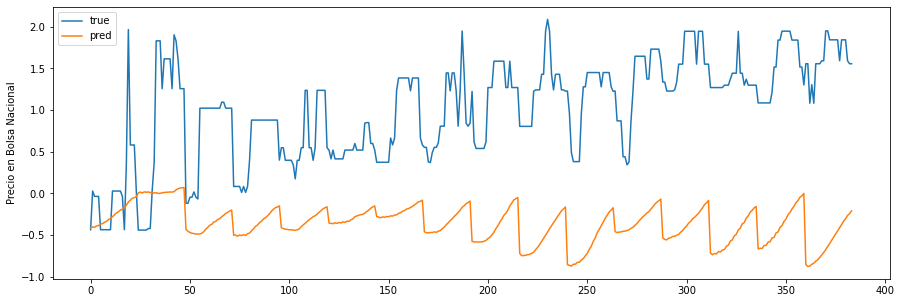

In [43]:
predictions = generate_predictions_style_1(inputs,labels,custom_cnn)
plot_comparison(labels,predictions)

In [44]:
performance['CNN'] = find_metrics_test(labels,predictions)

**Estilo 2:** Usando el último valor conocido.

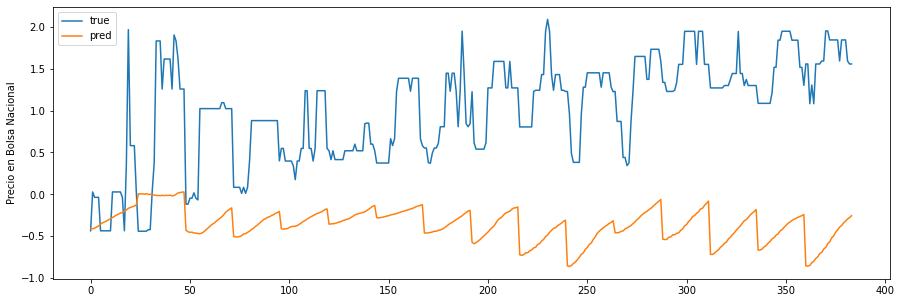

In [45]:
predictions = generate_predictions_style_2(inputs,labels,custom_cnn)
plot_comparison(labels,predictions)

## Metrics Summary

In [46]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.284578,0.443389,699.520508,95.341080
LSTM,0.564964,0.633131,2179.027588,95.138931
GRU,0.044396,0.117585,201.731155,32.246655
CNN,2.328961,1.306142,1145.303223,178.202393


In [47]:
pd.DataFrame(performance,index=['Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
RNN,1.381175,242.092270,4316.624069
LSTM,0.497894,133.123184,1575.679398
GRU,0.504103,279.401428,1354.356766
CNN,1.396872,204.069885,4671.233749
